In [1]:
# Import necessary packages
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Data Load & Pre-processing

In [2]:
# input folder
data_root = os.path.join(os.getcwd(),'input')

In [3]:
from data_preprocessing import *

In [5]:
df = load_data_from_local(data_root)
df.head(5)

Meta data size: 9022
c:\Users\pywong\Desktop\PolyU\COMP5434 Big Data Computing\Assignment\COMP5434-Big-Data-Computing\input\subset\subset\document_parses\pdf_json
total json files: 12000


100%|██████████| 8083/8083 [00:33<00:00, 238.25it/s]


,doc_num,paper_id,publish_time,doi,abstract,body_text,authors,title,journal,abstract_summary,language,processed_title,processed_abstract,processed_text,processed_title_list,processed_abstract_list,processed_text_list,all_text_list
0,0,0015cecc2298c3bdb9bda0e0b84b38ebdcca716f,2022-02-02,10.1007/s40744-022-00425-0,Coronavirus disease 2019 caused by the severe ...,Systemic inflammation is the hallmark of coron...,"Drosos, Alexandros A.. Pelechas, Eleftherios...",Colchicine Against SARS-CoV-2 Infection: What ...,Rheumatol Ther,Coronavirus disease 2019 caused by the severe ...,en,,coronavirus disease caused severe acute respir...,systemic inflammation hallmark coronavirus dis...,[],"[coronavirus, disease, caused, severe, acute, ...","[systemic, inflammation, hallmark, coronavirus...","[coronavirus, disease, caused, severe, acute, ..."
1,1,0016a5c32e9cea6002cf6f352ecdb5231c7e3194,2020-07-16,10.30699/ijp.2020.127312.2387,,Severe acute respiratory syndrome coronavirus ...,"Abdollahi, Alireza. shakoori, Abbas...",Comparison of Patient-collected and Lab Techni...,Iran J Pathol,Severe acute respiratory syndrome coronavirus ...,en,collected collected,,severe acute respiratory syndrome coronavirus ...,"[collected, collected]",[],"[severe, acute, respiratory, syndrome, coronav...","[collected, collected, severe, acute, respirat..."
2,2,0020e5c796f50e927b96ff0b7ea375b4745261a3,2020-05-08,10.1186/s12887-020-02112-x,Background: One major limitation for less inva...,Respiratory Distress Syndrome (RDS) affects 85...,"Chevallier, Marie. Durrmeyer, Xavier...",Propofol versus placebo (with rescue with keta...,BMC Pediatr,Background: One major limitation for less inva...,en,versus placebo rescue ketamine invasive surfac...,background major limitation invasive surfactan...,respiratory distress syndrome affects preterm ...,"[versus, placebo, rescue, ketamine, invasive, ...","[background, major, limitation, invasive, surf...","[respiratory, distress, syndrome, affects, pre...","[versus, placebo, rescue, ketamine, invasive, ..."
3,3,00234390dbc45e3370ac8f80cbd93cec3777ca92,2021-03-26,10.1016/j.ajur.2021.03.006,Objective: To identify the impact of COVID-19 ...,The World Health Organization (WHO) has announ...,"Raheem Ali, Abdel. Ghazwani, Yahya...",Impact of COVID-19 on endourology surgical pra...,Asian J Urol,Objective: To identify the impact of COVID-19 ...,en,endourology surgical practice national multice...,objective identify impact endourology surgical...,world health organization announced novel coro...,"[endourology, surgical, practice, national, mu...","[objective, identify, impact, endourology, sur...","[world, health, organization, announced, novel...","[endourology, surgical, practice, national, mu..."
4,4,0025fd87cfaf7953079b618771218b8de6893928,2021-09-06,10.3389/fcell.2021.748905,,"The concept of specialized ""membrane microdoma...","Garofalo, Tina. Misasi, Roberta...",Editorial: Targeting Lipid Rafts as a Strategy...,Front Cell Dev Biol,"The concept of specialized ""membrane microdoma...",en,,,concept specialized membrane microdomains refe...,[],[],"[concept, specialized, membrane, microdomains,...","[concept, specialized, membrane, microdomains,..."


# Histogram of year / journal

In [6]:
start_year = 1970
end_year = 2022

In [7]:
df['publish_year'] = df['publish_time'].dt.year
mask = (df['publish_year'] >= start_year) & (df['publish_year'] <= end_year)
df = df.loc[mask]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8041 entries, 0 to 8040
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   doc_num                  8041 non-null   int64         
 1   paper_id                 8041 non-null   object        
 2   publish_time             8041 non-null   datetime64[ns]
 3   doi                      8041 non-null   object        
 4   abstract                 8041 non-null   object        
 5   body_text                8041 non-null   object        
 6   authors                  8041 non-null   object        
 7   title                    8041 non-null   object        
 8   journal                  8041 non-null   object        
 9   abstract_summary         8041 non-null   object        
 10  language                 8041 non-null   object        
 11  processed_title          8041 non-null   object        
 12  processed_abstract       8041 non-null 

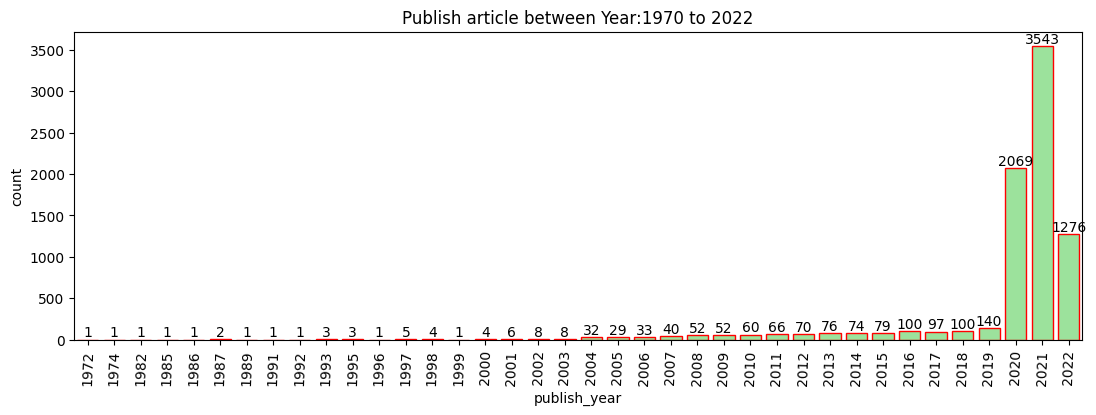

In [8]:
plt.figure(figsize=(13,4))
ax = sns.countplot(x='publish_year', data=df, color='lightgreen', edgecolor='red',)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', rotation=88)
plt.title('Publish article between Year:' + str(start_year) + ' to ' + str(end_year))
plt.show()

# Histogram of Journal

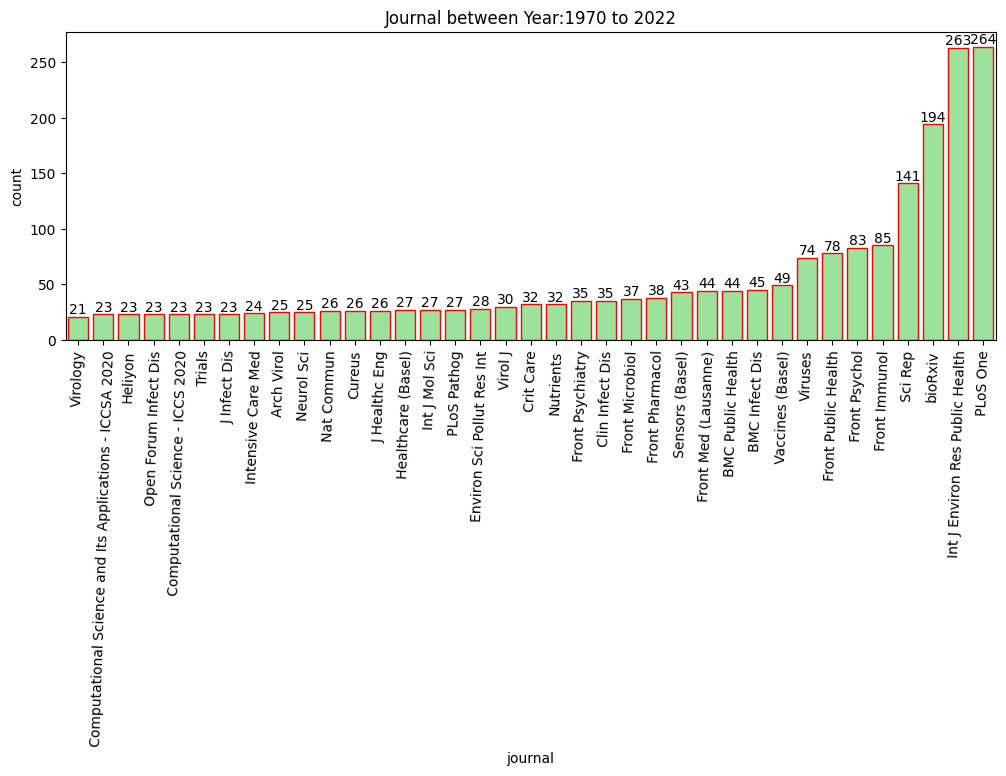

In [9]:
a = df.groupby('journal').filter(lambda x: len(x) > 20)
order = a.journal.value_counts(ascending=True).index

plt.figure(figsize=(12,4))
bx = sns.countplot(data=a, color='lightgreen', edgecolor='red', order=order, x='journal') 
bx.bar_label(bx.containers[0])
bx.tick_params(axis='x', rotation=88)
plt.title('Journal between Year:' + str(start_year) + ' to ' + str(end_year))
plt.show()

# Map-Reduce 

In [10]:
from map_reduce import *

In [11]:
# input
num_top_filtered = 50
num_top_unfilter = 50

metadata_path = os.path.join(data_root, 'meta_10k.csv')

In [12]:
documents_MR = load_documents_mr(metadata_path)

sorted_words, sorted_words_unfilter = map_reduce(documents_MR)

# Get the top 50 prevalent words
top_filtered = sorted_words[:num_top_filtered]
top_unfilter = sorted_words_unfilter[:num_top_unfilter]

In [13]:
# Step 6.1: Print the table of the top 50 prevalent words without stop words list
print(f"Top {num_top_unfilter} Prevalent Words without stopwords:")
print(f"{'ID':<4}{'Word':<20}{'Count'}")
print("-----------------------------")
for idx, (word, count) in enumerate(top_unfilter, start=1):
   print(f"{idx:<4}{word:<20}{count}")
print("\n"+"\n")

Top 50 Prevalent Words without stopwords:
ID  Word                Count
-----------------------------
1   the                 97935
2   of                  75152
3   and                 71142
4   in                  46376
5   to                  40334
6   a                   30698
7   with                20595
8   for                 19646
9   is                  12786
10  were                12217
11  that                11841
12  on                  11311
13  was                 11006
14  covid-19            10343
15  this                10102
16  as                  10067
17  we                  9942
18  by                  9331
19  from                8221
20  are                 7789
21  patients            7203
22  an                  7006
23  be                  6202
24  study               5251
25  or                  5157
26  at                  5110
27  have                4582
28  during              4384
29  health              4244
30  has                 4039
31  these   

In [14]:
# Step 6.2: Print the table of the top 50 prevalent words with IDs
print(f"Top {num_top_filtered} Prevalent Words:")
print(f"{'ID':<4}{'Word':<20}{'Count'}")
print("-----------------------------")
for idx, (word, count) in enumerate(top_filtered, start=1):
    print(f"{idx:<4}{word:<20}{count}")

Top 50 Prevalent Words:
ID  Word                Count
-----------------------------
1   covid-19            10343
2   patients            7203
3   study               5251
4   health              4244
5   data                3600
6   disease             3458
7   =                   3426
8   sars-cov-2          3371
9   clinical            2962
10  pandemic            2923
11  infection           2803
12  respiratory         2490
13  results             2486
14  associated          2484
15  coronavirus         2449
16  risk                2438
17  virus               2395
18  analysis            2342
19  viral               2192
20  model               2127
21  severe              2101
22  results:            1971
23  care                1970
24  different           1937
25  new                 1911
26  human               1886
27  social              1876
28  treatment           1847
29  however,            1844
30  based               1820
31  research            1806
32  high        

# Similarity Analysis

In [15]:
from similarity_analysis import *

In [16]:
# pick a target document to compare
target_doc_num = 0

# input feature size (number of token used)
feature_size = 2**12

random.seed(10)

In [17]:
# Label the document is the target or not
df['doc_type'] = 'other documents'
df.at[target_doc_num,'doc_type'] = 'target document'

In [18]:
# Define characteristic matrix by tokenizing the processed text

# Build feature with token count
count_vectorizer = CountVectorizer(max_features=feature_size)
X_count = count_vectorizer.fit_transform(df['processed_text'].values).toarray().T

# Clip count between 0 and 1 to only consider the token exists in document or not
X_clip = np.clip(X_count, 0, 1)

# Use TF-IDF as feature to only consider interseting words
tfidf_vectorizer = TfidfVectorizer(max_features=feature_size)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'].values).toarray().T

In [19]:
count_result = check_document_similarity(X_count,df,target_doc_num)
clip_result = check_document_similarity(X_clip,df,target_doc_num)
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)

## MinHash

Using token occurrence as document feature. Create a signature matrix using MinHash.
Compare the signature Jaccard similarity with the document L1 Norm (Hamming distance).

In [20]:
# Input to test the minhash performance
num_perm_list = list(range(50,200+1,50))

In [21]:
permutation_dict = minhash_with_different_permutation(df,X_clip,clip_result,target_doc_num,num_perm_list)
minhash_fine_turn_result = compare_minhash_fine_tune(permutation_dict)
minhash_fine_turn_result

,num_perm,correlation,pvalue
3,200,0.128771,4.439326e-31
2,150,0.430259,0.000000e+00
1,100,0.406207,3.557958e-317
0,50,0.247909,6.764643e-113


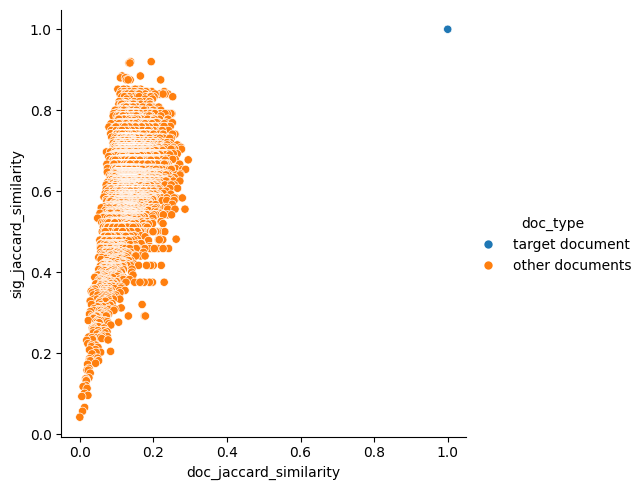

In [22]:
optimal_perm_num = int(minhash_fine_turn_result.sort_values(by=['correlation'],ascending=False).head(1)['num_perm'].values)
minhash_result = permutation_dict[optimal_perm_num]
sns.relplot(data=minhash_result,x='doc_jaccard_similarity', y='sig_jaccard_similarity', hue='doc_type')

In [23]:
minhash_result[['doc_num','sig_jaccard_similarity','abstract_summary','doc_type']].head(10)

,doc_num,sig_jaccard_similarity,abstract_summary,doc_type
0,0,1.000000,Coronavirus disease 2019 caused by the severe ...,target document
1316,1316,0.920000,High volumes of sedentary behaviour are associ...,other documents
3221,3221,0.920000,"In the COVID-19 scenario, patients undergoing ...",other documents
2214,2214,0.916667,The PRoteomics IDEntifications (PRIDE) databas...,other documents
58,58,0.916667,The aims of the present study were to determin...,other documents
7337,7337,0.884615,The widespread use of face masks by the genera...,other documents
2754,2754,0.884615,"Coronavirus disease , the ongoing global pande...",other documents
4520,4520,0.880000,The sudden lockdown recovers the health of the...,other documents
4765,4765,0.880000,The aim of the present study is to develop the...,other documents
1648,1648,0.880000,The estimation of evolutionary parameters prov...,other documents


## SimHash

Using TF-IDF as document feature. Create a signature matrix using SimHash.
Compare the signature Hamming distance with the document cosine similarity.

In [24]:
tfidf_feature_list = list(tfidf_vectorizer.get_feature_names_out())

feature_hash_md5 = get_feature_hash(tfidf_feature_list,'md5')
finger_print_list_md5 = get_finger_print_list(X_tfidf,feature_hash_md5)

feature_hash_sha1 = get_feature_hash(tfidf_feature_list,'sha1')
finger_print_list_sha1 = get_finger_print_list(X_tfidf,feature_hash_sha1)

In [25]:
# Check Performance
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)

md5 = check_simhash_similarity(finger_print_list_md5,target_doc_num)
md5 = tfidf_result.merge(md5,how='outer',on='doc_num')
md5 = md5.sort_values(by=['sig_hamming_distance'],ascending=True)

sha1 = check_simhash_similarity(finger_print_list_sha1,target_doc_num)
sha1 = tfidf_result.merge(sha1,how='outer',on='doc_num')
sha1 = sha1.sort_values(by=['sig_hamming_distance'],ascending=True)

if pearsonr(md5['doc_cosine_similarity'],md5['sig_hamming_distance']).statistic < pearsonr(sha1['doc_cosine_similarity'],sha1['sig_hamming_distance']).statistic:
    simhash_result = md5
else:
    simhash_result = sha1

ValueError: array must not contain infs or NaNs

In [26]:
md5[md5['doc_cosine_similarity'].isna()]

,doc_num,doc_l1_norm,doc_l2_norm,doc_cosine_similarity,abstract_summary,doc_type,sig_hamming_distance
2115,2115,16.817227,1.0,NaN,ORCID M. Elizabeth Halloran https://orcid.org/...,other documents,61


In [28]:
sha1[sha1['doc_cosine_similarity'].isna()]

,doc_num,doc_l1_norm,doc_l2_norm,doc_cosine_similarity,abstract_summary,doc_type,sig_hamming_distance
2115,2115,16.817227,1.0,NaN,ORCID M. Elizabeth Halloran https://orcid.org/...,other documents,85


In [27]:
md5[md5['sig_hamming_distance'].isna()]

,doc_num,doc_l1_norm,doc_l2_norm,doc_cosine_similarity,abstract_summary,doc_type,sig_hamming_distance


In [29]:
sha1[sha1['sig_hamming_distance'].isna()]

,doc_num,doc_l1_norm,doc_l2_norm,doc_cosine_similarity,abstract_summary,doc_type,sig_hamming_distance


In [ ]:
print(pearsonr(md5['doc_cosine_similarity'],md5['sig_hamming_distance']))
sns.relplot(data=md5,x='doc_cosine_similarity', y='sig_hamming_distance', hue='doc_type')

In [ ]:
print(pearsonr(sha1['doc_cosine_similarity'],sha1['sig_hamming_distance']))
sns.relplot(data=sha1,x='doc_cosine_similarity', y='sig_hamming_distance', hue='doc_type')

In [ ]:
simhash_result[['doc_num','sig_hamming_distance','abstract_summary','doc_type']].head(10)

## Doc2Vec

Word2Vec also need to consider token position for word embeding. Use the original text instead of the processed text for vectorization.

In [ ]:
# Use pretrained model to tokenize the documents.
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Use abstract summary instaed of body_test since it has less tokens.
# The abstract_summary field is a truncated version of the abstract.
# The truncated version of body_text is used if the document has no abstract.
# This field is not processed in stopwords removal to maintain the semantic meaning.

original_docs = list(df['abstract_summary'])
tagged_docs = tag_documents(tokenizer,original_docs)

In [ ]:
model = Doc2Vec()
model.build_vocab(tagged_docs)
model.train(tagged_docs,total_examples=model.corpus_count,epochs=20)

doc2vec_result = get_doc2vec_result(model,tokenizer,original_docs,target_doc_num,df)
doc2vec_result[['doc_num','doc2vec_similarity','abstract_summary','doc_type']].head(10)

## Comparsion

Comparing the performance of different document similarity search methods with the cosine similarity of document with TF-IDF word embeding.

In [ ]:
combine_result = get_combined_similarity_result(tfidf_result,count_result,clip_result,minhash_result,simhash_result,doc2vec_result)
rank_df = get_performance_rank(tfidf_result,count_result,clip_result,minhash_result,simhash_result,doc2vec_result)
rank_diff_df = get_performance_rank_diff(rank_df)

In [ ]:
plot_df = rank_diff_df.drop(columns=['doc_num']).melt().rename(columns={'value':'Rank Difference','variable':'Approach'})
sns.displot(plot_df, x='Rank Difference', hue='Approach')

In [ ]:
var_rank_diff = rank_diff_df.drop(columns=['doc_num','tfidf_doc_cosine']).var(axis=0)
var_rank_diff = var_rank_diff.reset_index().rename(columns={'index':'metric',0:'variance'})
var_rank_diff = var_rank_diff.sort_values(by=['variance'],ascending=True)
var_rank_diff

# Association Analysis

In [ ]:
from association_analysis import *

In [ ]:
# Input, can be word that is not in feature but in model
target_word_list = ['vaccine', 'pandemic', 'respiratory']

In [ ]:
if len(target_word_list) > 0:
    token_list = list(count_vectorizer.get_feature_names_out())
    index_dict = get_target_document_index(X_count,token_list,target_word_list)
    interested_list = list()
    for key in index_dict:
        interested_list += index_dict[key]
    print('Number of interested document: ',len(interested_list))
    df = df.iloc[interested_list]

## Association Rule (LDA)

In [ ]:
import gensim.corpora as corpora
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import pyLDAvis

import nltk
nltk.download('stopwords')

In [ ]:
# Set number of topics
num_topics = 4

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(df['all_text_list'])
# Create Corpus
texts = df['all_text_list']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha='auto', per_word_topics=True)
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['all_text_list'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)


## Wordcloud

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [ ]:
# Prepare Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
    width=4000,
    height=2000,
    max_words=10,
    prefer_horizontal=1.0,
    background_color='whitesmoke'
)

topics = lda_model.show_topics(formatted=False)
# Print the keywords for each topic
print(lda_model.print_topics())
print(lda_model.top_topics)

In [ ]:
fig, axes = plt.subplots(1, num_topics, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(cloud)
    plt.gca().set_title(str(start_year) + '-' + str(end_year) + ': Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.imshow(cloud, interpolation='bilinear')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
vis

## Prepare for Association Mining 

In [ ]:
min_support = 0.6
mine_col = 'all_text_list'

In [ ]:
# Pre-processing
te = TransactionEncoder()
te_ary = te.fit (df[mine_col]).transform(df[mine_col])
df_processd_text = pd.DataFrame (te_ary, columns=te.columns_)
print(df_processd_text)

## Association Rule (FP Growth)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth

In [ ]:
frq_items_fp = fpgrowth(df_processd_text, min_support=min_support, use_colnames=True)
print(frq_items_fp.head())
rules_fp = find_association_rules(frq_items_fp)
print(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']]) 
if len(rules_fp) > 0:
    #draw_catgraph (rules_fp, 10, topics, 'FP Growth with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')
    draw_graph (rules_fp, 5, topics, 'FP Growth with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')

## Association Rule (Apriori Algorithm)

In [ ]:
# Building the model 
frq_items_ap = apriori(df_processd_text, min_support = min_support, use_colnames = True) 
print(frq_items_ap.head())
rules_ap = find_association_rules(frq_items_ap)
print(rules_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']]) 
if len(rules_ap) > 0:
    #draw_catgraph (rules_ap, 10, topics, 'Apriori with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')
    draw_graph (rules_ap, 5, topics, 'Apriori with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')

# Clustering Analysis

# Knowledge Discovery

In [ ]:
from knowledge_discovery import *

In [ ]:
# Input dataframe with topic and labels for classification
topic_df = pd.DataFrame({
    'topic':['severity','illness','contagious','symptom'],
    'label':[
        ['mild','serious'],
        ['acute','chronic'],
        ['transmissible','noninfectious'],
        ['detectable','undetectable']
    ]
})